In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# View all columns from Measurement table
from sqlalchemy.inspection import inspect
columns = [column.name for column in inspect(Measurement).c]
columns

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
# View the top 5 records from Measurement table 
session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).limit(5).all()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# View all columns from Station table
columns = [column.name for column in inspect(Station).c]
columns

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [12]:
# View the records from Station table 
session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()

'2017-08-23'

In [14]:
# Find the most recent date in the data set - another way
last_date_str = session.query(func.max(Measurement.date)).scalar()
last_date_str

'2017-08-23'

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_date = dt.date.fromisoformat(last_date_str)
last_date
year_ago_date = last_date - dt.timedelta(days=365.24)
year_ago_date

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the dates and precipitation scores
dates_prcp_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_date).\
    all()
# dates_prcp_results

In [17]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
dates_prcp_results_df = pd.DataFrame(dates_prcp_results, columns=["Date", "Precipitation"])
dates_prcp_results_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [18]:
# Sort the dataframe by date
dates_prcp_results_df_sorted = dates_prcp_results_df.sort_values("Date").dropna().set_index("Date")
dates_prcp_results_df_sorted.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


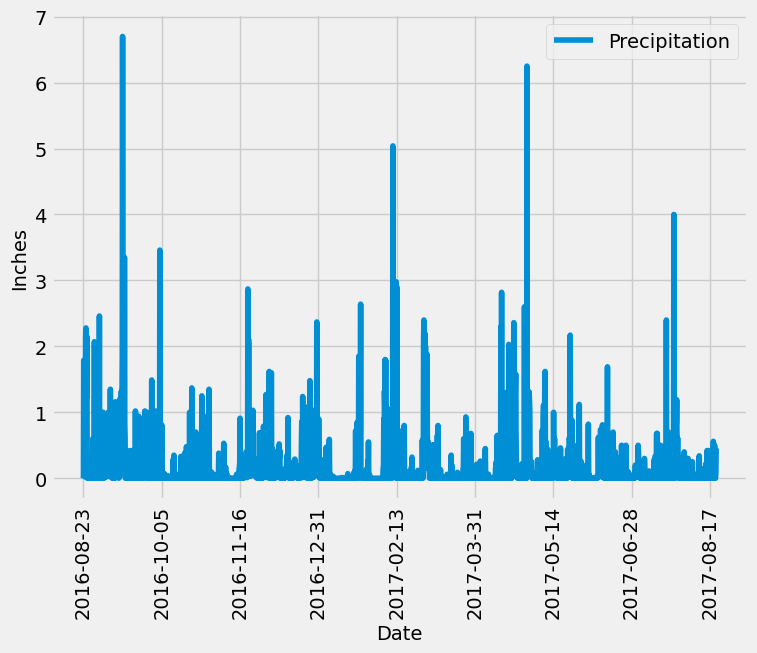

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
dates_prcp_results_df_sorted.plot(figsize=(8,6), rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig("images/bar.png")

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
dates_prcp_results_df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Station).count()
stations

9

In [22]:
highest_active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).\
    all()
highest_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
#  find the most-active stations with count
highest_active_stations[0]

('USC00519281', 2772)

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_record = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == highest_active_stations[0][0])
    .all()
)
print(station_record)

[(54.0, 85.0, 71.66378066378067)]


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print(f"Lowest Temperature: {station_record[0][0]} F")
print(f"Highest Temperature: {station_record[0][1]} F")
print(f"Average Temperature: {station_record[0][2]} F")

Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


In [26]:
temperature = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago_date).\
    filter(Measurement.station == highest_active_stations[0][0]).\
    order_by(Measurement.date).\
    all()

In [27]:
temperature_df = pd.DataFrame(temperature)
temperature_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


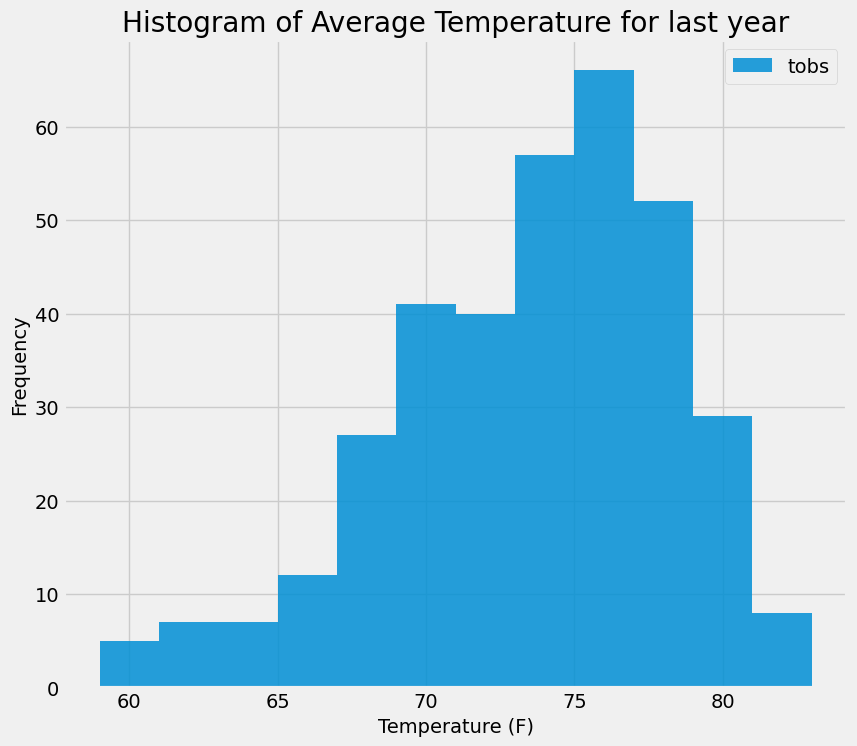

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_df.plot(kind="hist", bins=12, alpha=0.85, figsize=(9, 8))
plt.title("Histogram of Average Temperature for last year")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig("images/hist.png")

# Close Session

In [29]:
# Close Session
session.close()